Pose-Aware Face Recognition System

**Goal:** Implement face recognition that leverages head pose estimation (via MediaPipe Face Mesh) to improve matching accuracy, especially for non-frontal queries.

Library Imports and Setup

This block imports all necessary libraries, sets up the compute device (CUDA or CPU), and initializes the core models (FaceNet/InceptionResnetV1 for embeddings and MTCNN for face detection/alignment). It also initializes the MediaPipe Face Mesh.

In [2]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms
import cv2
import mediapipe as mp

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model initialization
# FaceNet model (InceptionResnetV1) for feature extraction
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
# MTCNN for face detection and alignment
mtcnn = MTCNN(image_size=160, margin=40, device=device, keep_all=False)

# MediaPipe Face Mesh initialization
mp_face_mesh = mp.solutions.face_mesh
# FaceMesh for estimating 3D face structure and landmarks
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

# Fallback transform for images where MTCNN fails to detect a face
fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pose mapping for gallery image filenames (e.g., '00' -> 'frontal')
POSE_MAPPING = {
    '00': 'frontal',
    '01': 'up',
    '02': 'down',
    '03': 'left',
    '04': 'right'
}

# Base path for dataset (MUST BE UPDATED)
# Replace this with your actual dataset path
BASE_PATH = 'E:/Projects/cv1'

Using device: cpu


Head Pose Estimation and Utility Functions

This block defines the core functions for head pose estimation using MediaPipe landmarks and for calculating face recognition scores (embedding extraction, cosine similarity, attention score, and pose-specific score).

In [3]:
def estimate_head_pose_mediapipe(image_path):
    """
    Estimate head pose using MediaPipe Face Mesh with simplified geometry
    Returns yaw, pitch, roll angles and categorical pose
    """
    img = cv2.imread(image_path)
    if img is None:
        return None, None, None, 'unknown'
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        return None, None, None, 'unknown'
    
    face_landmarks = results.multi_face_landmarks[0]
    
    # Get image dimensions
    img_h, img_w = img.shape[:2]
    
    # --- Simplified Geometry-based Pose Estimation ---
    
    def get_2d_point(idx):
        return np.array([
            face_landmarks.landmark[idx].x * img_w,
            face_landmarks.landmark[idx].y * img_h
        ])
    
    # Key points: Left/Right Eye Outer (33, 263), Nose Tip (1), Left/Right Mouth (61, 291), Nose Bridge (168)
    left_eye = get_2d_point(33)
    right_eye = get_2d_point(263)
    nose_tip = get_2d_point(1)
    left_mouth = get_2d_point(61)
    right_mouth = get_2d_point(291)
    
    # Calculate YAW (left-right rotation) based on nose deviation from eye center
    eye_center_x = (left_eye[0] + right_eye[0]) / 2
    face_width = np.linalg.norm(right_eye - left_eye)
    nose_to_center = nose_tip[0] - eye_center_x
    yaw_ratio = nose_to_center / (face_width / 2) if face_width > 0 else 0
    yaw = np.clip(yaw_ratio * 45, -90, 90) # Empirical scaling
    
    # Calculate PITCH (up-down rotation) based on vertical nose position
    eye_center_y = (left_eye[1] + right_eye[1]) / 2
    mouth_center_y = (left_mouth[1] + right_mouth[1]) / 2
    face_height = abs(mouth_center_y - eye_center_y)
    expected_nose_y = eye_center_y + 0.4 * face_height 
    nose_deviation_y = (nose_tip[1] - expected_nose_y) / face_height if face_height > 0 else 0
    pitch = np.clip(nose_deviation_y * 60, -45, 45) # Empirical scaling
    
    # Calculate ROLL (head tilt) based on eye alignment
    eye_angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0])
    roll = np.degrees(eye_angle)
    
    # Categorize pose
    pose_category = categorize_pose(yaw, pitch, roll)
    
    return yaw, pitch, roll, pose_category

def categorize_pose(yaw, pitch, roll):
    """Categorize pose based on yaw and pitch angles"""
    if yaw is None or pitch is None:
        return 'unknown'
    
    yaw_threshold = 20  # degrees - for left/right head turn
    pitch_threshold = 15  # degrees - for up/down head tilt
    
    if abs(yaw) > yaw_threshold:
        return 'right' if yaw > 0 else 'left'
    elif abs(pitch) > pitch_threshold:
        return 'down' if pitch > 0 else 'up'
    else:
        return 'frontal'

def draw_pose_annotation(image_path, yaw, pitch, roll, pose_category):
    """Draw pose annotation on image for visualization"""
    img = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    if yaw is not None:
        text = f"Yaw: {yaw:.1f}°\nPitch: {pitch:.1f}°\nRoll: {roll:.1f}°\nPose: {pose_category}"
    else:
        text = f"Pose: {pose_category}"
    
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    bbox = draw.textbbox((10, 10), text, font=font)
    # Draw semi-transparent background
    draw.rectangle(bbox, fill=(0, 0, 0, 128)) 
    draw.text((10, 10), text, fill=(0, 255, 255), font=font)
    
    return img

def extract_embedding(img_path):
    """Extract face embedding from image using MTCNN and FaceNet"""
    img = Image.open(img_path).convert('RGB')
    face_tensor = mtcnn(img)
    
    if face_tensor is None:
        # Fallback to applying transform directly if MTCNN fails
        face_tensor = fallback_transform(img)
    
    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        # L2-normalize the embedding
        embedding = F.normalize(embedding, p=2, dim=1) 
    
    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings"""
    return np.dot(emb1, emb2)

def attention_score(query_emb, gallery_embs, temperature=1.0):
    """
    Calculate attention-weighted similarity score (Baseline Method)
    S_p = sum(Attention_i * Similarity_i)
    """
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)
    S_p = np.sum(attention * sims)
    return S_p, attention, sims

def pose_specific_score(query_emb, gallery_dict, estimated_pose):
    """
    Calculate similarity focusing on matching pose (Pose-Aware Method)
    Returns pose-specific score and overall attention score for all persons.
    """
    all_scores = {}
    
    for person_id, pose_data in gallery_dict.items():
        pose_sims = {}
        # Calculate similarity to all pose images for the person
        for pose_id, emb in pose_data.items():
            sim = cosine_similarity(query_emb, emb)
            pose_name = POSE_MAPPING.get(pose_id, pose_id)
            pose_sims[pose_name] = sim
        
        # 1. Overall Attention Score (Baseline)
        gallery_embs = list(pose_data.values())
        overall_score, attention, sims = attention_score(query_emb, gallery_embs)
        
        # 2. Pose-Specific Score
        if estimated_pose in pose_sims:
            # Use similarity to the gallery image matching the estimated pose
            pose_specific = pose_sims[estimated_pose]
        else:
            # Fallback: use the max similarity among all poses for this person
            pose_specific = max(pose_sims.values())
        
        all_scores[person_id] = {
            'overall': overall_score,
            'pose_specific': pose_specific,
            'pose_sims': pose_sims,
            'attention': attention,
            'all_sims': sims
        }
    
    return all_scores

Gallery Building (Embedding and Pose Extraction)

This block iterates through the gallery directory to extract embeddings and estimate the head pose for each gallery image using the MediaPipe function.

In [4]:
print("\n" + "="*80)
print("BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

# IDs for people in the gallery (assumed folder names)
gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery_dict = {}     # Stores embeddings: {person_id: {pose_id: embedding}}
gallery_images = {}   # Stores PIL images: {person_id: {pose_id: image}}
gallery_poses = {}    # Stores pose estimates: {person_id: {pose_id: pose_data}}

for person_id in gallery_ids:
    folder_path = os.path.join(BASE_PATH, "gallery", person_id)
    
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue
    
    pose_embeddings = {}
    person_images = {}
    person_poses = {}
    
    print(f"\nProcessing gallery person {person_id}:")
    for img_name in sorted(os.listdir(folder_path)):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        img_path = os.path.join(folder_path, img_name)
        # Assumes gallery image name is the pose ID (e.g., '00.jpg', '01.jpg')
        pose_id = img_name.split('.')[0] 
        
        # Estimate head pose using MediaPipe
        yaw, pitch, roll, pose_cat = estimate_head_pose_mediapipe(img_path)
        person_poses[pose_id] = {
            'yaw': yaw, 'pitch': pitch, 'roll': roll, 
            'category': pose_cat, 'expected': POSE_MAPPING.get(pose_id, 'unknown')
        }
        
        print(f"  {pose_id}.jpg: Expected={POSE_MAPPING.get(pose_id, 'unknown'):>8} | "
              f"Detected={pose_cat:>8} | Yaw={yaw:>6.1f}° Pitch={pitch:>6.1f}° Roll={roll:>6.1f}°" 
              if yaw is not None else f"  {pose_id}.jpg: Pose detection failed")
        
        emb = extract_embedding(img_path)
        pose_embeddings[pose_id] = emb
        person_images[pose_id] = Image.open(img_path)
    
    gallery_dict[person_id] = pose_embeddings
    gallery_images[person_id] = person_images
    gallery_poses[person_id] = person_poses

print(f"\nGallery built with {len(gallery_dict)} people")


BUILDING GALLERY WITH MEDIAPIPE HEAD POSE ESTIMATION

Processing gallery person 00:


c:\Users\Al Shahbaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


  00.jpg: Expected= frontal | Detected= frontal | Yaw=   3.4° Pitch=  11.2° Roll=  -2.1°
  01.jpg: Expected=      up | Detected= frontal | Yaw=   0.3° Pitch=  -4.8° Roll=  -3.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -1.2° Pitch=  26.8° Roll=  -2.0°
  03.jpg: Expected=    left | Detected=    left | Yaw= -55.3° Pitch=   8.6° Roll= -13.4°
  04.jpg: Expected=   right | Detected=   right | Yaw=  68.4° Pitch=   3.5° Roll=   0.7°

Processing gallery person 01:
  00.jpg: Expected= frontal | Detected= frontal | Yaw=  -1.7° Pitch=  13.6° Roll=  -3.9°
  01.jpg: Expected=      up | Detected= frontal | Yaw=  -4.0° Pitch=  -4.0° Roll=   0.1°
  02.jpg: Expected=    down | Detected=    down | Yaw=  -2.4° Pitch=  18.1° Roll=  -1.6°
  03.jpg: Expected=    left | Detected=    left | Yaw= -36.0° Pitch=  11.5° Roll=  -4.5°
  04.jpg: Expected=   right | Detected=   right | Yaw=  27.5° Pitch=  12.1° Roll=  -3.1°

Processing gallery person 02:
  00.jpg: Expected= frontal | Detected= frontal 

Query Processing and Comparison

This block iterates through the query images, estimates their pose, extracts their embeddings, and calculates both the Baseline (Overall Attention) and Pose-Aware (Pose-Specific) scores against the gallery. It stores the results for later analysis.

In [5]:
# Process queries with MediaPipe head pose estimation
queries_path = os.path.join(BASE_PATH, 'queries')

if not os.path.exists(queries_path):
    print(f"Queries folder not found: {queries_path}. Please check BASE_PATH.")
    # You should update BASE_PATH or create the queries directory.
    raise FileNotFoundError(f"Queries folder not found: {queries_path}")

query_files = sorted([f for f in os.listdir(queries_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

print("\n" + "="*80)
print("PROCESSING QUERIES WITH MEDIAPIPE HEAD POSE ESTIMATION")
print("="*80)

results = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    
    # 1. Estimate head pose from query image
    yaw, pitch, roll, estimated_pose = estimate_head_pose_mediapipe(query_path)
    
    # 2. Extract embedding
    query_emb = extract_embedding(query_path)
    
    # Ground truth is parsed from the query filename (e.g., 'query_00.jpg' -> '00')
    ground_truth = query_name.split('_')[1].split('.')[0]
    is_known = ground_truth in gallery_ids
    
    # 3. Get scores (Baseline and Pose-Aware)
    all_scores = pose_specific_score(query_emb, gallery_dict, estimated_pose)
    
    # Predict using overall score (Baseline)
    predicted_overall = max(all_scores.keys(), key=lambda p: all_scores[p]['overall'])
    score_overall = all_scores[predicted_overall]['overall']
    
    # Predict using pose-specific score (Pose-Aware)
    predicted_pose = max(all_scores.keys(), key=lambda p: all_scores[p]['pose_specific'])
    score_pose = all_scores[predicted_pose]['pose_specific']
    
    result = {
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'yaw': yaw, 'pitch': pitch, 'roll': roll,
        'estimated_pose': estimated_pose,
        'predicted_overall': predicted_overall,
        'score_overall': score_overall,
        'predicted_pose_specific': predicted_pose,
        'score_pose_specific': score_pose,
        'correct_overall': (predicted_overall == ground_truth) if is_known else None,
        'correct_pose_specific': (predicted_pose == ground_truth) if is_known else None,
        'all_scores': all_scores
    }
    
    results.append(result)

print(f"\nProcessed {len(results)} queries")


PROCESSING QUERIES WITH MEDIAPIPE HEAD POSE ESTIMATION

Processed 42 queries


Results Analysis and Metrics

This block prints detailed results, calculates the overall accuracy comparison, and defines a function to compute per-pose precision, recall, and F1-score for both methods.

In [6]:
# Print detailed results and overall metrics
print("\n" + "="*80)
print("IDENTIFICATION RESULTS")
print("="*80)

known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]

correct_overall = sum(1 for r in known_results if r['correct_overall'])
correct_pose = sum(1 for r in known_results if r['correct_pose_specific'])
total_known = len(known_results)

print(f"\nKnown people (00-06): {correct_overall}/{total_known} = {100*correct_overall/total_known:.1f}% (BASELINE - Attention)")
print(f"Known people (00-06): {correct_pose}/{total_known} = {100*correct_pose/total_known:.1f}% (POSE-AWARE - MediaPipe)")
print(f"Unknown people (07): {len(unknown_results)} queries")
print("="*80)

print("\nDetailed Results (Known) - POSE-AWARE METHOD:")
for r in known_results:
    symbol = "✓" if r['correct_pose_specific'] else "✗"
    pose_str = f"Pose: {r['estimated_pose']:>8} (Y:{r['yaw']:>5.1f}° P:{r['pitch']:>5.1f}° R:{r['roll']:>5.1f}°)" if r['yaw'] is not None else f"Pose: {r['estimated_pose']:>8}"
    print(f"{symbol} {r['query']:<15} → Pred: {r['predicted_pose_specific']}, Truth: {r['ground_truth']}, "
          f"Score: {r['score_pose_specific']:.3f} | {pose_str}")

# Calculate metrics by pose
def calculate_metrics_by_pose(results, use_pose_specific=False):
    """Calculate accuracy, precision, recall, and F1-score per pose"""
    pose_metrics = {}
    
    for pose in list(POSE_MAPPING.values()) + ['unknown']:
        # Filter results for the current pose and known people
        pose_results = [r for r in results if r['estimated_pose'] == pose and r['is_known']]
        
        if not pose_results:
            continue
        
        pred_key = 'predicted_pose_specific' if use_pose_specific else 'predicted_overall'
        correct = sum(1 for r in pose_results if r[f'correct_{"pose_specific" if use_pose_specific else "overall"}'])
        total = len(pose_results)
        accuracy = correct / total if total > 0 else 0
        
        # Calculate per-person (micro/macro) metrics
        precisions = []
        recalls = []
        
        for person_id in gallery_ids:
            tp = sum(1 for r in pose_results if r['ground_truth'] == person_id and r[pred_key] == person_id)
            fp = sum(1 for r in pose_results if r['ground_truth'] != person_id and r[pred_key] == person_id)
            fn = sum(1 for r in pose_results if r['ground_truth'] == person_id and r[pred_key] != person_id)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # Only include non-zero metrics if person had queries in this pose
            if (tp + fn) > 0 or (tp + fp) > 0:
                precisions.append(precision)
                recalls.append(recall)

        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
        
        pose_metrics[pose] = {
            'accuracy': accuracy,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1_score': f1_score,
            'num_queries': total,
            'correct': correct
        }
    
    return pose_metrics

# Calculate and display metrics
print("\n" + "="*80)
print("METRICS BY HEAD POSE - BASELINE (Attention-based)")
print("="*80)
metrics_baseline = calculate_metrics_by_pose(known_results, use_pose_specific=False)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for pose, metrics in sorted(metrics_baseline.items()):
    print(f"{pose:<10} {metrics['num_queries']:<10} "
          f"{metrics['accuracy']:<12.3f} {metrics['precision']:<12.3f} "
          f"{metrics['recall']:<12.3f} {metrics['f1_score']:<12.3f}")

print("\n" + "="*80)
print("METRICS BY HEAD POSE - POSE-AWARE MATCHING (MediaPipe)")
print("="*80)
metrics_pose = calculate_metrics_by_pose(known_results, use_pose_specific=True)

print(f"\n{'Pose':<10} {'Queries':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for pose, metrics in sorted(metrics_pose.items()):
    print(f"{pose:<10} {metrics['num_queries']:<10} "
          f"{metrics['accuracy']:<12.3f} {metrics['precision']:<12.3f} "
          f"{metrics['recall']:<12.3f} {metrics['f1_score']:<12.3f}")


IDENTIFICATION RESULTS

Known people (00-06): 27/30 = 90.0% (BASELINE - Attention)
Known people (00-06): 28/30 = 93.3% (POSE-AWARE - MediaPipe)
Unknown people (07): 12 queries

Detailed Results (Known) - POSE-AWARE METHOD:
✓ 01_00.jpg       → Pred: 00, Truth: 00, Score: 0.633 | Pose:  frontal (Y:  3.1° P:  4.7° R:  3.8°)
✓ 04_01.jpg       → Pred: 01, Truth: 01, Score: 0.721 | Pose:  frontal (Y:  2.3° P: 12.9° R: -1.7°)
✓ 05_02.jpg       → Pred: 02, Truth: 02, Score: 0.712 | Pose:  frontal (Y: 17.4° P:  8.8° R:-13.8°)
✓ 07_03.jpg       → Pred: 03, Truth: 03, Score: 0.677 | Pose:  frontal (Y:  0.3° P: 11.6° R:  4.9°)
✓ 08_00.jpg       → Pred: 00, Truth: 00, Score: 0.593 | Pose:  frontal (Y:  6.2° P:  3.7° R:  1.8°)
✓ 11_03.jpg       → Pred: 03, Truth: 03, Score: 0.761 | Pose:     down (Y:  8.9° P: 15.7° R: -4.4°)
✓ 13_04.jpg       → Pred: 04, Truth: 04, Score: 0.684 | Pose:  unknown
✗ 16_04.jpg       → Pred: 05, Truth: 04, Score: 0.491 | Pose:  frontal (Y:  4.1° P:  7.0° R:  2.3°)
✓ 17_

Visualization Generation

This final block generates and saves comparison charts and detailed image grids to visualize the head pose distribution, the accuracy difference between the two methods, and a visual breakdown of predictions for a sample of queries per pose.


GENERATING VISUALIZATIONS
Comparison chart saved to: e:\Projects\cvProject\mediapipe_pose_comparison.png

Generating annotated image grids...
Results for down pose saved to: e:\Projects\cvProject\mediapipe_results_down.png
Results for frontal pose saved to: e:\Projects\cvProject\mediapipe_results_frontal.png
Results for left pose saved to: e:\Projects\cvProject\mediapipe_results_left.png
Results for right pose saved to: e:\Projects\cvProject\mediapipe_results_right.png
Results for unknown pose saved to: e:\Projects\cvProject\mediapipe_results_unknown.png

ANALYSIS COMPLETE

Summary (MediaPipe Head Pose Estimation):
  Baseline Accuracy: 90.0%
  Pose-Aware Accuracy: 93.3%
  Improvement: 1 queries (+3.3%)

Generated visualization files in: e:\Projects\cvProject


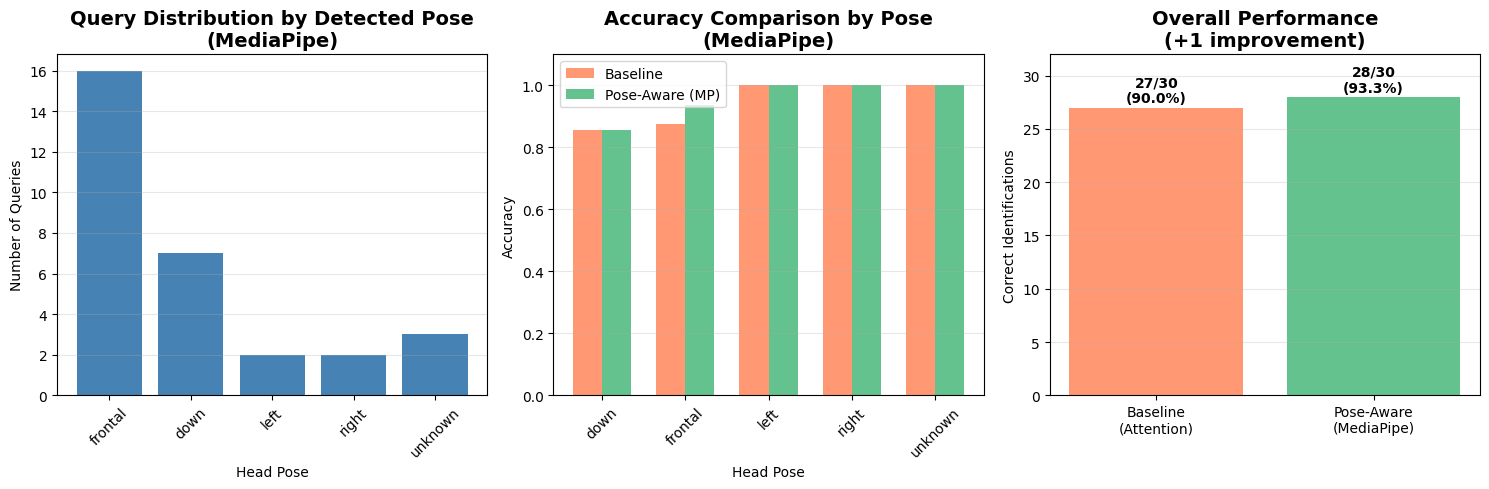

In [7]:
# Visualization
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create pose distribution and accuracy comparison visualization
plt.figure(figsize=(15, 5))

# --- Plot 1: Query Distribution by Pose ---
plt.subplot(1, 3, 1)
pose_counts = {}
for pose in list(POSE_MAPPING.values()) + ['unknown']:
    count = len([r for r in known_results if r['estimated_pose'] == pose])
    if count > 0:
        pose_counts[pose] = count

plt.bar(pose_counts.keys(), pose_counts.values(), color='steelblue')
plt.title('Query Distribution by Detected Pose\n(MediaPipe)', fontsize=14, fontweight='bold')
plt.xlabel('Head Pose')
plt.ylabel('Number of Queries')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)


# --- Plot 2: Accuracy Comparison by Pose ---
plt.subplot(1, 3, 2)
if metrics_baseline:
    x = np.arange(len(metrics_baseline))
    width = 0.35
    
    # Ensure metrics_pose has keys matching metrics_baseline for comparison
    labels = sorted(metrics_baseline.keys())
    baseline_acc = [metrics_baseline[p]['accuracy'] for p in labels]
    # Use metrics_pose if available, otherwise assume 0 for comparison plot
    pose_acc = [metrics_pose.get(p, {'accuracy': 0})['accuracy'] for p in labels] 
    
    plt.bar(x - width/2, baseline_acc, width, label='Baseline', alpha=0.8, color='coral')
    plt.bar(x + width/2, pose_acc, width, label='Pose-Aware (MP)', alpha=0.8, color='mediumseagreen')
    plt.xlabel('Head Pose')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison by Pose\n(MediaPipe)', fontsize=14, fontweight='bold')
    plt.xticks(x, labels, rotation=45)
    plt.legend()
    plt.ylim([0, 1.1])
    plt.grid(axis='y', alpha=0.3)


# --- Plot 3: Overall Performance Comparison ---
plt.subplot(1, 3, 3)
improvement = correct_pose - correct_overall
plt.bar(['Baseline\n(Attention)', 'Pose-Aware\n(MediaPipe)'], 
        [correct_overall, correct_pose], 
        color=['coral', 'mediumseagreen'], alpha=0.8)
plt.ylabel('Correct Identifications')
plt.title(f'Overall Performance\n({improvement:+d} improvement)', 
          fontsize=14, fontweight='bold')
plt.ylim([0, total_known + 2])
for i, v in enumerate([correct_overall, correct_pose]):
    plt.text(i, v + 0.5, f'{v}/{total_known}\n({100*v/total_known:.1f}%)', 
             ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()
save_path = 'mediapipe_pose_comparison.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Comparison chart saved to: {os.path.abspath(save_path)}")


# Generate visual grids with pose annotations
print("\nGenerating annotated image grids...")
pose_id_map = {v: k for k, v in POSE_MAPPING.items()}

for pose in sorted(set([r['estimated_pose'] for r in known_results])):
    pose_results = [r for r in known_results if r['estimated_pose'] == pose]
    if not pose_results:
        continue
    
    num_show = min(8, len(pose_results))
    # Create subplots for the query, prediction, ground truth, and score analysis
    fig, axes = plt.subplots(num_show, 4, figsize=(16, 4*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Detected Pose: {pose.upper()} ({len(pose_results)} queries) - MediaPipe', 
                 fontsize=16, fontweight='bold')
    
    for idx, r in enumerate(pose_results[:num_show]):
        query_path = os.path.join(queries_path, r['query'])
        
        # 1. Annotated query image
        annotated_query = draw_pose_annotation(query_path, r['yaw'], r['pitch'], r['roll'], r['estimated_pose'])
        axes[idx, 0].imshow(annotated_query)
        axes[idx, 0].set_title(f"Query: {r['query']}", fontsize=10)
        axes[idx, 0].axis('off')
        
        # 2. Predicted match (pose-aware)
        predicted_id = r['predicted_pose_specific']
        pose_sims = r['all_scores'][predicted_id]['pose_sims']
        # Find the best pose in the gallery for visualization
        best_gallery_pose = max(pose_sims.keys(), key=lambda p: pose_sims[p])
        gallery_pose_id = pose_id_map.get(best_gallery_pose, '00')
        pred_img = gallery_images[predicted_id].get(gallery_pose_id, gallery_images[predicted_id]['00'])
        
        axes[idx, 1].imshow(pred_img)
        is_correct = r['correct_pose_specific']
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        axes[idx, 1].set_title(f'{symbol} Predicted: ID {predicted_id}\nGallery Pose: {best_gallery_pose}', 
                               fontsize=10, color=color, fontweight='bold')
        axes[idx, 1].axis('off')
        
        # 3. Ground truth
        ground_truth_id = r['ground_truth']
        true_img = gallery_images[ground_truth_id].get(gallery_pose_id, gallery_images[ground_truth_id]['00'])
        
        axes[idx, 2].imshow(true_img)
        axes[idx, 2].set_title(f'Ground Truth: ID {ground_truth_id}\nGallery Pose: {best_gallery_pose}', 
                               fontsize=10, color='blue', fontweight='bold')
        axes[idx, 2].axis('off')
        
        # 4. Score comparison
        correct_score = r['all_scores'][ground_truth_id]['pose_specific']
        pred_score = r['score_pose_specific']
        
        axes[idx, 3].text(0.5, 0.5, 
                          f'Similarity Scores:\n\n'
                          f'Predicted ID {predicted_id}:\n{pred_score:.4f}\n\n'
                          f'True ID {ground_truth_id}:\n{correct_score:.4f}\n\n'
                          f'Difference:\n{abs(pred_score - correct_score):.4f}',
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[idx, 3].set_title('Score Analysis', fontsize=10)
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    save_path = f'mediapipe_results_{pose}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Results for {pose} pose saved to: {os.path.abspath(save_path)}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nSummary (MediaPipe Head Pose Estimation):")
print(f"  Baseline Accuracy: {100*correct_overall/total_known:.1f}%")
print(f"  Pose-Aware Accuracy: {100*correct_pose/total_known:.1f}%")
print(f"  Improvement: {correct_pose - correct_overall} queries ({100*(correct_pose-correct_overall)/total_known:+.1f}%)")
print(f"\nGenerated visualization files in: {os.path.abspath('.')}")

# Cleanup
face_mesh.close()